<a href="https://colab.research.google.com/github/EmmaCOo/Consumer-Complaints-Dataset-for-NLP/blob/main/Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# import libraries

import pandas as pd
import numpy as np
import json
import os
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder, StandardScaler, Normalizer
from sklearn.metrics import confusion_matrix, accuracy_score, plot_confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

from collections import Counter
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
import string
from nltk.tokenize import word_tokenize
import re


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


### Load data set

In [2]:
df = pd.read_csv('/content/drive/MyDrive/complaints_processed.csv')
df.head()

,Unnamed: 0,product,narrative
0,0,credit_card,purchase order day shipping amount receive pro...
1,1,credit_card,forwarded message date tue subject please inve...
2,2,retail_banking,forwarded message cc sent friday pdt subject f...
3,3,credit_reporting,payment history missing credit report speciali...
4,4,credit_reporting,payment history missing credit report made mis...


### The 'product' will be the the target label and 'narrative' will be the features.

In [3]:
# Drop insignificant column 'Unnamed: 0'
df = df.drop(columns=['Unnamed: 0'], axis = 1)
df.tail()

,product,narrative
162416,debt_collection,name
162417,credit_card,name
162418,debt_collection,name
162419,credit_card,name
162420,credit_reporting,name


In [4]:
# drop the rows that contain 'name' 
df = df[df["narrative"].str.contains("name") == False] 
df.tail()

,product,narrative
162408,credit_card,set received item listed refunding account tha...
162409,retail_banking,yr thru expecting monies account deposit dolla...
162412,debt_collection,zero contact made debt supposedly resolved fou...
162413,mortgages_and_loans,zillow home loan nmls nmls actual quote provid...
162414,debt_collection,zuntafi sent notice willing settle defaulted s...


MISSING VALUES AND DUPLICATES

In [5]:
# check missing values
print((~df.duplicated()).sum())

105377


In [6]:
print('Lenght of Data Frame Before')
len(df)

Lenght of Data Frame Before


137583

In [7]:
# drop the duplicated records
df.drop_duplicates(keep=False,inplace=True)

In [8]:
print('Lenght of Data Frame After Dropping Duplicates:')
len(df)

Lenght of Data Frame After Dropping Duplicates:


94999

In [9]:
# data types and shape of the data
print(df.dtypes)
print(df.shape)

product      object
narrative    object
dtype: object
(94999, 2)


### **TARGET CLASSES**

### **DISTRIBUTION OF TARGET CLASSES**

In [10]:
# target classes' distribution
df['product'].value_counts(normalize=True)*100

credit_reporting       39.225676
debt_collection        17.580185
mortgages_and_loans    17.532816
credit_card            13.710671
retail_banking         11.950652
Name: product, dtype: float64

### **VISUAL DISTRIBUTION OF TARGET CLASSES**

Text(0.5, 1.0, 'Distribution of Target Classes')

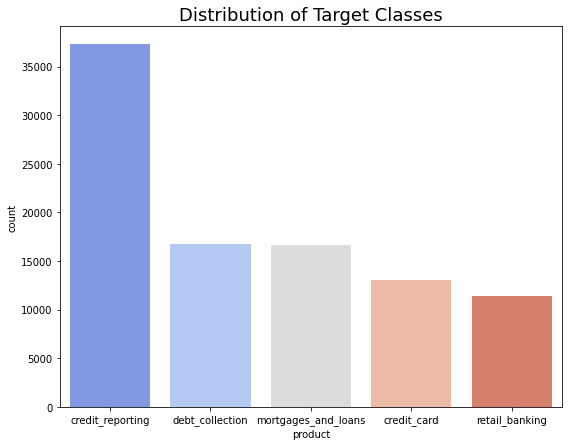

In [11]:
# Figure size
plt.figure(figsize=(9,7))

# Count plot
ax = sns.countplot(x = 'product', data = df, palette="coolwarm", order = df['product'].value_counts().index)

# Add title
plt.title('Distribution of Target Classes', fontsize=18)

From the value_counts and countplot graph, the distribution of credit_reporting is highest with 56.2%, debt_collection (14.3%), mortgage_and_loans (11.7%), credit_card (9.6%),and retail_banking (8.3%). 

Overall class imbalance was observed between the target classes. 

### **LABEL ENCDOING OF TARGET CLASSES**

In [12]:
le = LabelEncoder()
df['product'] = le.fit_transform(df['product'])
df.head()

,product,narrative
0,0,purchase order day shipping amount receive pro...
2,4,forwarded message cc sent friday pdt subject f...
3,1,payment history missing credit report speciali...
4,1,payment history missing credit report made mis...
5,1,payment history missing credit report made mis...


In [13]:
df['product'].value_counts(normalize=True)*100

1    39.225676
2    17.580185
3    17.532816
0    13.710671
4    11.950652
Name: product, dtype: float64

### **PREPROCESSING FOR FEATURE COLUMN 'NARRATIVE'**

### REMOVE PUNCTUATION

In [14]:
import string
string.punctuation   # print lists of punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [15]:
# Function to remove punctuation
def remove_punc(text):
  text_nonpunc ="".join([char for char in str(text) if char not in string.punctuation])
  return text_nonpunc

# applyiing remove_punc function into 'narrative' and saving as a 'no_punctuation' column
df['no_punctuation'] = df['narrative'].apply(lambda x: remove_punc(x))

df.head()

,product,narrative,no_punctuation
0,0,purchase order day shipping amount receive pro...,purchase order day shipping amount receive pro...
2,4,forwarded message cc sent friday pdt subject f...,forwarded message cc sent friday pdt subject f...
3,1,payment history missing credit report speciali...,payment history missing credit report speciali...
4,1,payment history missing credit report made mis...,payment history missing credit report made mis...
5,1,payment history missing credit report made mis...,payment history missing credit report made mis...


### TOKENIZATION 

Tokenization is a process of parsing the text string into different sections (tokens). 

In [16]:
#function to tokenize the text
def tokenize(text):
  tokens = re.split('\W+', text)
  return tokens

# add new column 'tokenized' to df
df['tokenized'] = df['no_punctuation'].apply(lambda x: tokenize(x)) # convert lower case to all words

df.head()

,product,narrative,no_punctuation,tokenized
0,0,purchase order day shipping amount receive pro...,purchase order day shipping amount receive pro...,"[purchase, order, day, shipping, amount, recei..."
2,4,forwarded message cc sent friday pdt subject f...,forwarded message cc sent friday pdt subject f...,"[forwarded, message, cc, sent, friday, pdt, su..."
3,1,payment history missing credit report speciali...,payment history missing credit report speciali...,"[payment, history, missing, credit, report, sp..."
4,1,payment history missing credit report made mis...,payment history missing credit report made mis...,"[payment, history, missing, credit, report, ma..."
5,1,payment history missing credit report made mis...,payment history missing credit report made mis...,"[payment, history, missing, credit, report, ma..."


### REMOVING STOP WORDS

Stop words such as 'is', 'and', 'the' etc will be removed since they don't contritube much information for the NLP.  

For this project, spaCy library will be used. 

In [17]:
# lists of stopwords
stopword = nltk.corpus.stopwords.words('english')
print(stopword)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [18]:
import spacy
#loading the english language small model of spacy
en = spacy.load('en_core_web_sm')
sw_spacy = en.Defaults.stop_words
print(sw_spacy)

{'many', 'or', 'every', 'must', 'hundred', 'seemed', 'we', 'amongst', 'twenty', 'few', 'rather', 'three', 'never', 'whole', 'thru', 'forty', "n't", 'as', 'serious', '‘ll', 'toward', 'still', 'behind', 'them', 'nobody', 'with', 'cannot', 'moreover', 'eight', 'although', 'fifteen', 'front', 'sixty', 'regarding', 'then', 'all', 'whereas', 'wherein', 'ourselves', 'and', 'are', 'get', '‘ve', 'whence', 'beforehand', '‘d', 'where', 'ever', 'at', 'over', '’s', 'thereafter', 'were', 'without', 'out', 'might', 'others', 'beyond', 'did', 'when', 'within', 'mine', 'between', 'own', 'seems', 'was', 'whither', 'using', 'though', 'how', 'last', 'her', 'after', 'hence', 'until', 'these', 'hereafter', 'well', 'meanwhile', 'somewhere', 'an', '‘s', 'they', 'some', 'always', 'nine', 'yet', 'each', 'into', 'alone', 'one', 'towards', 'neither', 'hereupon', 'nor', 'say', 'another', 'further', '’m', 'name', 'show', 'back', 'side', "'ve", 'someone', 'had', 'below', 'himself', 'ours', 'full', 'often', 'more', '

In [19]:
# function to remove stopwords
def remove_sw(tokenized_list):
  func_sw = [word for word in tokenized_list if word not in sw_spacy]
  return func_sw

# add new column 'no_stopword' to df
df['no_stopword'] = df['tokenized'].apply(lambda x: remove_sw(x))

df.head()

,product,narrative,no_punctuation,tokenized,no_stopword
0,0,purchase order day shipping amount receive pro...,purchase order day shipping amount receive pro...,"[purchase, order, day, shipping, amount, recei...","[purchase, order, day, shipping, receive, prod..."
2,4,forwarded message cc sent friday pdt subject f...,forwarded message cc sent friday pdt subject f...,"[forwarded, message, cc, sent, friday, pdt, su...","[forwarded, message, cc, sent, friday, pdt, su..."
3,1,payment history missing credit report speciali...,payment history missing credit report speciali...,"[payment, history, missing, credit, report, sp...","[payment, history, missing, credit, report, sp..."
4,1,payment history missing credit report made mis...,payment history missing credit report made mis...,"[payment, history, missing, credit, report, ma...","[payment, history, missing, credit, report, mi..."
5,1,payment history missing credit report made mis...,payment history missing credit report made mis...,"[payment, history, missing, credit, report, ma...","[payment, history, missing, credit, report, mi..."


## **LEMMATIZATION**

Lemmatization is performed to remove the extra words such as "easily" to "easy" while keeping the context of the words.  

In [20]:
lm = nltk.WordNetLemmatizer()

def lemmat(tokenized_text):
  text = [lm.lemmatize(word) for word in tokenized_text]
  return text

# add new column 'lemmatized' to df
df['lemmatized'] = df['no_stopword'].apply(lambda x: lemmat(x))

df.head()

,product,narrative,no_punctuation,tokenized,no_stopword,lemmatized
0,0,purchase order day shipping amount receive pro...,purchase order day shipping amount receive pro...,"[purchase, order, day, shipping, amount, recei...","[purchase, order, day, shipping, receive, prod...","[purchase, order, day, shipping, receive, prod..."
2,4,forwarded message cc sent friday pdt subject f...,forwarded message cc sent friday pdt subject f...,"[forwarded, message, cc, sent, friday, pdt, su...","[forwarded, message, cc, sent, friday, pdt, su...","[forwarded, message, cc, sent, friday, pdt, su..."
3,1,payment history missing credit report speciali...,payment history missing credit report speciali...,"[payment, history, missing, credit, report, sp...","[payment, history, missing, credit, report, sp...","[payment, history, missing, credit, report, sp..."
4,1,payment history missing credit report made mis...,payment history missing credit report made mis...,"[payment, history, missing, credit, report, ma...","[payment, history, missing, credit, report, mi...","[payment, history, missing, credit, report, mi..."
5,1,payment history missing credit report made mis...,payment history missing credit report made mis...,"[payment, history, missing, credit, report, ma...","[payment, history, missing, credit, report, mi...","[payment, history, missing, credit, report, mi..."


### LENGTH OF SAMPLE BEFORE AND AFTER PREPROCESSING 

In [21]:
df['length_before_cleaning'] = df['narrative'].apply(lambda x: len(x))  # length of raw texts
df['length_after_cleaning'] = df['lemmatized'].apply(lambda x: len(x))  # length of cleand words
df.head()

,product,narrative,no_punctuation,tokenized,no_stopword,lemmatized,length_before_cleaning,length_after_cleaning
0,0,purchase order day shipping amount receive pro...,purchase order day shipping amount receive pro...,"[purchase, order, day, shipping, amount, recei...","[purchase, order, day, shipping, receive, prod...","[purchase, order, day, shipping, receive, prod...",1705,203
2,4,forwarded message cc sent friday pdt subject f...,forwarded message cc sent friday pdt subject f...,"[forwarded, message, cc, sent, friday, pdt, su...","[forwarded, message, cc, sent, friday, pdt, su...","[forwarded, message, cc, sent, friday, pdt, su...",1230,147
3,1,payment history missing credit report speciali...,payment history missing credit report speciali...,"[payment, history, missing, credit, report, sp...","[payment, history, missing, credit, report, sp...","[payment, history, missing, credit, report, sp...",903,110
4,1,payment history missing credit report made mis...,payment history missing credit report made mis...,"[payment, history, missing, credit, report, ma...","[payment, history, missing, credit, report, mi...","[payment, history, missing, credit, report, mi...",851,102
5,1,payment history missing credit report made mis...,payment history missing credit report made mis...,"[payment, history, missing, credit, report, ma...","[payment, history, missing, credit, report, mi...","[payment, history, missing, credit, report, mi...",849,102


### **VISUALIZATIONS OF MOST FREQUENT USED WORDS FROM RAW TEXT SENTENCES VS LEMMATIZED WORDS**


### RAW TEXT SENTENCES

In [22]:
# Top 10 Most Used Words from the raw narrative column
from collections import Counter
count = Counter(" ".join(df["narrative"]).split()).most_common(10)
print(count)

[('account', 173252), ('credit', 169709), ('payment', 94453), ('report', 83508), ('information', 65332), ('time', 54238), ('loan', 53798), ('would', 53554), ('card', 50663), ('bank', 49455)]


In [23]:
raw_top = pd.DataFrame(count, columns = ['Words','Frequency'])
raw_top

,Words,Frequency
0,account,173252
1,credit,169709
2,payment,94453
3,report,83508
4,information,65332
5,time,54238
6,loan,53798
7,would,53554
8,card,50663
9,bank,49455


### LEMMATIZED WORDS

TOP 10 MOST FREQUENTS WORDS FROM LEMMATIZED WORDS

In [24]:
reviews = df["lemmatized"].values.tolist()
flat_list = [item for elem in reviews for item in elem if str(item) != 'nan']

fdist1 = nltk.FreqDist(flat_list)
lem_top = pd.DataFrame(fdist1.most_common(10), columns = ['Words','Frequency'])
lem_top

,Words,Frequency
0,account,173252
1,credit,169709
2,payment,94453
3,report,83508
4,information,65332
5,time,54238
6,loan,53798
7,card,50664
8,bank,49455
9,company,47495


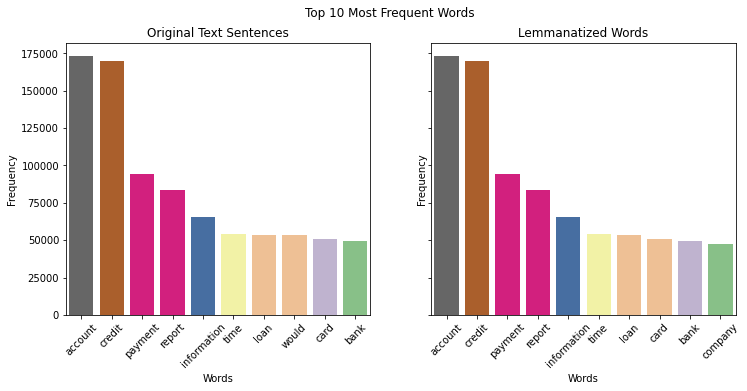

In [25]:
fig, ax = plt.subplots(1,2, figsize=(12, 5), sharey=True)
fig.suptitle('Top 10 Most Frequent Words')

sns.barplot(x='Words', y= 'Frequency', data = raw_top , palette = 'Accent_r', ax = ax[0])
sns.barplot(x='Words', y= 'Frequency', data = lem_top , palette = 'Accent_r', ax = ax[1])

ax[0].set_title('Original Text Sentences')
ax[1].set_title('Lemmanatized Words')

ax[0].tick_params(axis='x', labelrotation=45)
ax[1].tick_params(axis='x', labelrotation=45)
fig.show()

### **DATA PARTITIONING** 

In [26]:
# Clean Data Frame with only 'product' and 'lemmatized' columns
clean_df = df[['product','lemmatized']]

# split feature and target column 
X = clean_df['lemmatized']
y = df[['product']]

print (X.head(2))
print (y.head(2))

0    [purchase, order, day, shipping, receive, prod...
2    [forwarded, message, cc, sent, friday, pdt, su...
Name: lemmatized, dtype: object
   product
0        0
2        4


### **VECTORIZATION**

Vectorization is to convert the text data into numerical data/vector for the NLP machine learning. TF-IDF method will be used for this project. 

In [27]:
X_array = X.astype(str)

In [28]:
# Vectorization
# for train data set
vectorizer = TfidfVectorizer()
X_vec = vectorizer.fit_transform(X_array)

# get feature names
feat_names = vectorizer.get_feature_names()
feat_names

# create da data frame called X from bag of words features
X_tf = pd.DataFrame.sparse.from_spmatrix(X_vec, columns = feat_names)
X_tf.head()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,aa,aaa,aaadvantage,aaarrrrgghhhhhh,aab,aac,aaccount,aacount,aadvantage,aadvantages,...,zombie,zone,zoned,zoning,zoo,zoom,zoomed,zsaleh,zuntafi,zwicker
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [29]:
# train(70%) and test (30%) splitting with stratified samples
X_train, X_test, y_train, y_test = train_test_split(X_tf,y, test_size = 0.3, random_state = 42, stratify = y)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((66499, 38924), (66499, 1), (28500, 38924), (28500, 1))

In [30]:
X_vec

<94999x38924 sparse matrix of type '<class 'numpy.float64'>'
	with 4374528 stored elements in Compressed Sparse Row format>

In [31]:
train_vec, test_vec, y_vec, test_yvec = train_test_split(X_vec,y, test_size = 0.3, random_state = 42)

### MODELS

In [32]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf.fit(X_train,y_train)

rf_pred= rf.predict(X_test)

print(accuracy_score(y_test, rf_pred))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


0.8359298245614035
